![SPIE AL logo](http://spie.org/Images/Graphics/ConferenceLogo/al.gif)
# Defect Prediction Machine Learning Example


### For the SPIE Short Course "[Data Analytics and Machine Learning in Semiconductor Manufacturing: Applications for Physical Design, Process and Yield Optimization](http://spie.org/AL/course/data-analytics-and-machine-learning-in-semiconductor-manufacturing-applications-for-physical-design-process-and-yield-optimization)"

__Authors:__  
Jason Cain and Luigi Capodieci  
February 2018
   
***

## Problem statement

In this example, we will be creating a classifier system to predict whether or not a certain patterning defect mode will occur based on two inline measurements (scanner exposure dose and focus). This defect mode is typically only detected in post-etch inspection. However, if we could predict whether the defect will occur immediately after the exposure step (based on available scanner data) we could simplify the rework process and avoid potential yield loss.  
  
Our approach will loosely follow the [OSEMN](http://www.dataists.com/2010/09/a-taxonomy-of-data-science/) process. The computational work will be handled by [Python](https://www.python.org/) and associated libraries.


## Setting up the environment  

First we'll import some useful libraries. In particular:
* [matplotlib](https://matplotlib.org/) - data visualization
* [pandas](https://pandas.pydata.org/) - data manipulation and analysis
* [numpy](http://www.numpy.org/) - numerical computing with arrays, linear algebra, etc.
* [scikit-learn](http://scikit-learn.org/stable/) - machine learning

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv, merge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

## Step 1: Obtain data

In this exercise we're given two data files, both in CSV (comma-separated values) format:
* __[exposure_data.csv](exposure_data.csv)__ - sample lithography scanner log containing the following columns:
    * Fab - _Fab name_ (`string`)
    * LithoCell - _Lithography tool name_ (`string`)
    * Stage - _Scanner stage number_ (`int`)
    * Wafer - _Wafer ID_ (`string`)
    * FieldX - _Column number of field on wafer_ (`int`)
    * FieldY - _Row number of field on wafer_ (`int`)
    * Lot - _Lot ID_ (`string`)
    * Date - _Exposure date_ (`string`)
    * Time - _Exposure time_ (`string`)
    * Focus - _Focus setting in nm_ (`float`)
    * ExpDose - _Exposure dose in mJ_ (`float`)  
  
This will be the 'feature' data.
  
  
* __[inspection_data.csv](inspection_data.csv)__ - sample wafer inspection data for a particular defect type containing the following columns:
    * Lot - _Lot ID_ (`string`)
    * Wafer - _Wafer ID_ (`string`)
    * FieldX - _Column number of field on wafer_ (`int`)
    * FieldY - _Row number of field on wafer_ (`int`)
    * InspTool - _Inspection tool name_ (`string`)
    * Defect - _Boolean value representing the absence (0) or presence (1) of the defect_ (`int`)
  
This will be the 'label' data.    


_Note: all data in this exercise was generated randomly and does not correspond to any actual fab data._

## Step 2: Scrub data

We'll start by using the `pandas` [read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) function to load the exposure data into a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) instance. Then we'll need to check to see if there are any missing values.

In [2]:
# Read in the focus/dose data with the first row (i.e., row 0) as the header
exp_data = read_csv('exposure_data.csv', header=0)

# Check for missing values
print("Total number of rows in DataFrame: " + str(exp_data.shape[0]))
print("Number of rows with missing values by column:")
print(exp_data.isnull().sum())


Total number of rows in DataFrame: 1050
Number of rows with missing values by column:
Fab           0
LithoCell     0
Stage         0
Wafer         0
FieldX        0
FieldY        0
Lot           0
Date          0
Time          0
Focus        25
ExpDose      25
dtype: int64


We see that both the 'Focus' and 'ExpDose' columns have some missing values. We need to deal with that somehow--in this case we'll simply drop any row that has a missing value (represented in the DataFrame by a 'NaN' or "not a number" value).

In [3]:
# drop rows with missing values, printing the row counts before and after
exp_data.dropna(inplace=True)
# Check for missing values
print("Total number of rows in DataFrame: " + str(exp_data.shape[0]))
print("Number of rows with missing values by column:")
print(exp_data.isnull().sum())



Total number of rows in DataFrame: 1000
Number of rows with missing values by column:
Fab          0
LithoCell    0
Stage        0
Wafer        0
FieldX       0
FieldY       0
Lot          0
Date         0
Time         0
Focus        0
ExpDose      0
dtype: int64


We're left with 1000 rows of data that have zero missing values. Now we'll repeat the process for the inspection data:

In [4]:
# Read in the inspection data
insp_data = read_csv('inspection_data.csv', header=0)

# Check for missing values
print("Total number of rows in dataframe: " + str(insp_data.shape[0]))
print("Number of rows with missing values by column:")
print(insp_data.isnull().sum())


Total number of rows in dataframe: 1025
Number of rows with missing values by column:
Lot          0
Wafer        0
FieldX       0
FieldY       0
InspTool     0
Defect      25
dtype: int64


Now remove the rows with missing values and check the results:

In [5]:
# drop rows with missing values, printing the row counts before and after
insp_data.dropna(inplace=True)
# Check for missing values
print("Total number of rows in dataframe: " + str(insp_data.shape[0]))
print("Number of rows with missing values by column:")
print(insp_data.isnull().sum())


Total number of rows in dataframe: 1000
Number of rows with missing values by column:
Lot         0
Wafer       0
FieldX      0
FieldY      0
InspTool    0
Defect      0
dtype: int64


Now that we have filtered the two datasets together, we need to merge them together to associate the correct inspection results for each focus/exposure data point. We'll do this by using the `pandas` [merge](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) function and matching the lot, wafer, field X, and field Y values:

In [6]:
# merge data into a single DataFrame
merged_data = merge(exp_data, insp_data, how='inner', on=['Lot', 'Wafer', 'FieldX', 'FieldY'], sort=False)

# Print a few rows to see what the results look like
print(merged_data[0:5])

     Fab LithoCell  Stage  Wafer  FieldX  FieldY       Lot        Date  \
0  FAB_A    LITH15      2     17      -7      -3  6V78TJ10  05/21/2017   
1  FAB_A    LITH06      2      2      -4       6  3JZX3ZUK  11/27/2017   
2  FAB_A    LITH02      2     20       7      -6  SKFPM6YR  05/16/2017   
3  FAB_A    LITH14      2      4       7      -1  VINI5MWO  08/10/2017   
4  FAB_A    LITH15      2     11      -5      -3  7SCWPT3O  09/05/2017   

       Time      Focus    ExpDose InspTool  Defect  
0  09:00 AM -39.736527   9.967321  INSP14C     1.0  
1  07:40 PM -19.423390   9.466734  INSP14C     0.0  
2  03:29 PM  77.052599  10.212761  INSP08A     1.0  
3  12:14 PM  -3.179968   9.748477   INSP12     0.0  
4  05:53 AM -18.461324  10.645196   INSP11     0.0  


To work with the data, we'll convert the `pandas` DataFrame into a `numpy` array:

In [7]:
data_array = merged_data.as_matrix()

# Print a few rows for comparison with the DataFrame view in the previous step
print(data_array[0:4,:])

[['FAB_A' 'LITH15' 2 17 -7 -3 '6V78TJ10' '05/21/2017' '09:00 AM'
  -39.73652744160897 9.967321151486813 'INSP14C' 1.0]
 ['FAB_A' 'LITH06' 2 2 -4 6 '3JZX3ZUK' '11/27/2017' '07:40 PM'
  -19.423390181736263 9.466733784324699 'INSP14C' 0.0]
 ['FAB_A' 'LITH02' 2 20 7 -6 'SKFPM6YR' '05/16/2017' '03:29 PM'
  77.05259896915155 10.212761264675523 'INSP08A' 1.0]
 ['FAB_A' 'LITH14' 2 4 7 -1 'VINI5MWO' '08/10/2017' '12:14 PM'
  -3.1799682215673677 9.748476954975498 'INSP12' 0.0]]


Finally, we'll slice the large array into two smaller arrays:  
* `X`, containing the 'feature' data (i.e., focus and exposure dose) - column indexes 9 and 10 of the merged data
* `Y`, containing the 'label' data (where '0' represents no defect and '1' represents a defect) - column index 12 of the merged data

In [8]:
X = data_array[:,9:11].astype(float)
Y = data_array[:,12].astype(int)

## Step 3: Explore data



Now that we have the data loaded, let's plot it to get a feel for what it looks like. We'll use a scatter plot with dose and focus as the two axis variables and use different colors for the two labels (defect/no defect).

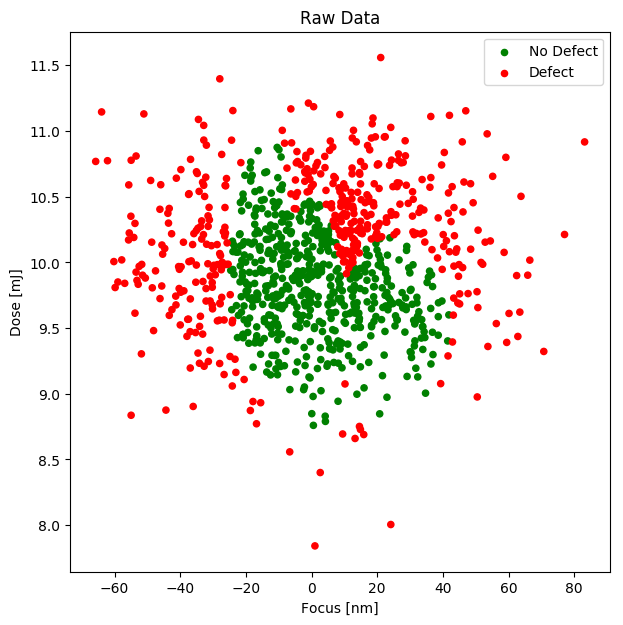

In [9]:
mask = Y.astype(bool)
a = 20*np.ones(mask.shape)
a_good = np.ma.masked_where(mask, a)
a_bad = np.ma.masked_where(np.logical_not(mask), a)
fig = plt.figure(figsize=(6,6), dpi=100)
axes = fig.add_axes([0.1, 0.1, 0.9, 0.9])
axes.scatter(X[:,0], X[:,1], s=a_good, color='green', label='No Defect')
axes.scatter(X[:,0], X[:,1], s=a_bad, color='red', label='Defect')
axes.set_xlabel('Focus [nm]')
axes.set_ylabel('Dose [mJ]')
axes.set_title('Raw Data');
axes.legend();

Here we can see that there does appear to be a relationship between scanner dose/focus and the occurrence of a defect--the 'no-defect' observations seem to be clustered together into a region (often referred to as a process window). We should be able to train a model to learn the boundaries of this region and predict whether or not a defect will occur based on a given dose/focus observation.  
  
Since we have labeled data we'll use a [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning) approach. Before fitting our model, we'll split the data into two sets: a training set that will be used to train the model and a test set that will be used to evaluate the performance on new data outside the training set. The `scikit-learn` library offers a [function](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) that can handle this task.

In [10]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state = 2018)

In addition, we may note that the range of our two features is quite different: the range of focus values is approximately 140nm, while the range of dose values is only about 3.5 mJ. While this isn't too extreme, some efforts to normalize the data so that all the features have a similar mean and range may improve the performance of the optimizer used to fit the model. Again, `scikit-learn` provides functions to make this step easy.

In [11]:
# Create a 'StandardScaler' instance and adjust the normalization transforms to the training data
scaler = StandardScaler()
scaler.fit(X_train)

# Now apply the transformations to the the training and test sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Step 4: Model

To classify the data between defects and non-defects, we'll train a [multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) (MLP) model. The `scikit-learn` library the [MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) class for this purpose. Although it has many options that can be configured, most of them have sensible defaults for our application so we'll only specify the number of hidden layers in the network (3) and the number of neurons in each layer (40 for each). The `random_state` argument is a seed value related to random initialization of the model weights and is specified to ensure consistent results across different runs.
  
In practice, these are important meta-parameters of the model and some experimentation may be needed to find good values to use for a particular application.

In [12]:
# Define a multi-layer perceptron classifier with three hidden layers, each with 40 neurons
mlp = MLPClassifier(hidden_layer_sizes=(40,40,40), random_state = 2018)

# Fit the classifier to the training data
mlp.fit(X_train,y_train);

Now that the classifier has been trained on the training set we'll use it to make predictions for the test data set:

In [13]:
predictions = mlp.predict(X_test)

## Step 5: Interpret

How can we evaluate how well our classifier did on the test data? One way is to use a 'confusion matrix.' In this example, the confusion matrix would be defined as follows (in this case, a 'positive' indicates a defect):

\begin{vmatrix}
\mathrm{true\ negatives\ (TN)} & \mathrm{false\ positives\ (FP)}\\
\mathrm{false\ negatives\ (FN)} & \mathrm{true\ positives\ (TP)}
\end{vmatrix}
  
We can obtain the confusion matrix very simply:

In [14]:
print(confusion_matrix(y_test,predictions))

[[108   2]
 [  2  88]]


In this case, our classifier correctly predicted 108 cases where there is no defect and 88 cases where there is a defect. However, it incorrectly predicted that there was no defect in 2 cases where there actually was (false negatives) and that there was a defect in 2 cases where there actually was no defect (false positives)

We can also generate a classification report with some key metrics. The __precision__ is defined as the ratio of the number of true positives (defects in this case) predicted to the total number of positives (true and false) predicted by the classifier, _i.e.,_ $\frac{TP}{TP+FP}$. The __recall__ is defined as the ratio of the number of true positives predicted to the total number of positives in the data, _i.e.,_ $\frac{TP}{TP+FN}$. The __F-score__ is defined as the harmonic mean of the precision and recall, _i.e.,_ $\frac{2\ \times\ precision\ \times\ recall}{precision\ +\ recall}$.

In [15]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98       110
          1       0.98      0.98      0.98        90

avg / total       0.98      0.98      0.98       200



Overall, this classifier seems to do fairly well, especially for a first pass.

## Application

Now that we have a classifier that seems to predict the occurrence of the defect based on the scanner data with reasonable accuracy we could consider making it part of the process control scheme for the fab. The factory automation software could route scanner data (including focuse and exposure dose) to the classifier and take the appropriate action based on the prediction made. If the classifier predicts a defect, the lot could be flagged for closer inspection or rework. Otherwise the wafer can proceed through the process flow normally.  
  
Of course, any change to the process (_e.g._, nominal process conditions, materials, etc.) could impact the accuracy of the classifier. After any such change is made it may be necessary to retrain the model.

## Summary
In this example, we followed the OSEMN approach to data science to build a classifier system to predict whether a printability defect was likely two occur based on two observed features (scanner dose and focus). We started with a set of raw data consisting of 1,000 observations of dose and focus along with corresponding labels for each observation indicating whether a defect occurred in those conditions or not. 
  
After 'scrubbing' the data to remove or resolve any invalid entries, we used some visualization tools to explore the data. We observed that the way that the 'good' observations were clustered together might lend itself to a classification approach. After some further work to normalize the data and split it into training and test sets, we were ready to build our classifier.  
  
The classifier was implemented as a Multi-Layer Perceptron network using components of the `scikit-learn` library. Even with the use of default values for many meta-parameters of the model we obtained reasonable results quickly. Students are encouraged to experiment further to see if there are additional opportunities for improvement.

## References for further exploration

The following is a small sampling of the many resources available for learning about machine learning, deep learning, and artificial intelligence:  

### Online courses 
* [Machine Learning](https://www.coursera.org/learn/machine-learning) (_Coursera_)
* [Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning) (_Coursera_)
* [Intro to Machine Learning](https://www.udacity.com/course/intro-to-machine-learning--ud120) (_Udacity_)
* [Practical Deep Learning for Coders](https://course.fast.ai/) (_fast.ai_)
  
### Books
* [_Deep Learning_](http://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville. Available online for free.
* [_Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow, 2nd Edition_](https://amazon.com/Python-Machine-Learning-scikit-learn-TensorFlow/dp/1787125939) by Sebastian Raschka and Vahid Mirjalili
* [_Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems_](https://smile.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291/) by Aurélien Géron

### Papers
* A [curated list](https://github.com/terryum/awesome-deep-learning-papers) of the 100 most influential deep learning papers in recent years

### Other machine learning libraries
* [Tensorflow](https://www.tensorflow.org/)
* [Keras](https://keras.io/)

### Other resources
* [Kaggle](https://www.kaggle.com/) - a good source of datasets to experiment with
* There are many resources available on GitHub; here is a good [starting point](https://github.com/collections/machine-learning) for more exploration.
* A [more thorough list](https://github.com/ChristosChristofidis/awesome-deep-learning) of online resources
* [Dive into Machine Learning](https://github.com/hangtwenty/dive-into-machine-learning)